In [1]:
attributes_list = ['upperBodyLogo', 'lowerBodyThinStripes', 'upperBodyThinStripes', 'upperBodyThickStripes', 'accessoryHeadphone', 'carryingBabyBuggy', 'carryingBackpack', 'hairBald', 'footwearBoots', 'carryingOther', 'carryingShoppingTro', 'carryingUmbrella', 'carryingFolder', 'accessoryHairBand', 'accessoryHat', 'lowerBodyHotPants', 'upperBodyJacket', 'lowerBodyJeans', 'accessoryKerchief', 'footwearLeatherShoes', 'hairLong', 'lowerBodyLongSkirt', 'upperBodyLongSleeve', 'carryingLuggageCase', 'carryingMessengerBag', 'accessoryMuffler', 'accessoryNothing', 'carryingNothing', 'upperBodyNoSleeve', 'carryingPlasticBags', 'footwearSandals', 'footwearShoes', 'hairShort', 'lowerBodyShorts', 'upperBodyShortSleeve', 'lowerBodyShortSkirt', 'footwearSneakers', 'footwearStocking', 'upperBodySuit', 'carryingSuitcase', 'lowerBodySuits', 'accessorySunglasses', 'upperBodySweater', 'lowerBodyTrousers', 'upperBodyTshirt', 'upperBodyOther', 'upperBodyVNeck', 'personalLess15', 'personalLess30', 'personalLess45', 'personalLess60', 'personalLarger60', 'lowerBodyCapri', 'lowerBodyCasual', 'upperBodyCasual', 'personalFemale', 'lowerBodyFormal', 'upperBodyFormal', 'lowerBodyPlaid', 'personalMale', 'upperBodyPlaid']
print(attributes_list)

['upperBodyLogo', 'lowerBodyThinStripes', 'upperBodyThinStripes', 'upperBodyThickStripes', 'accessoryHeadphone', 'carryingBabyBuggy', 'carryingBackpack', 'hairBald', 'footwearBoots', 'carryingOther', 'carryingShoppingTro', 'carryingUmbrella', 'carryingFolder', 'accessoryHairBand', 'accessoryHat', 'lowerBodyHotPants', 'upperBodyJacket', 'lowerBodyJeans', 'accessoryKerchief', 'footwearLeatherShoes', 'hairLong', 'lowerBodyLongSkirt', 'upperBodyLongSleeve', 'carryingLuggageCase', 'carryingMessengerBag', 'accessoryMuffler', 'accessoryNothing', 'carryingNothing', 'upperBodyNoSleeve', 'carryingPlasticBags', 'footwearSandals', 'footwearShoes', 'hairShort', 'lowerBodyShorts', 'upperBodyShortSleeve', 'lowerBodyShortSkirt', 'footwearSneakers', 'footwearStocking', 'upperBodySuit', 'carryingSuitcase', 'lowerBodySuits', 'accessorySunglasses', 'upperBodySweater', 'lowerBodyTrousers', 'upperBodyTshirt', 'upperBodyOther', 'upperBodyVNeck', 'personalLess15', 'personalLess30', 'personalLess45', 'personal

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = ""
from keras.applications import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing import image
from keras.models import Model
from keras.applications.imagenet_utils import decode_predictions
import numpy as np
import cv2
from cv2 import *
import matplotlib.pyplot as plt
%matplotlib inline
import scipy as sp
from scipy.misc import toimage
import sys
sys.path.append("..")
from src.network.GoogleLenet_gap import GoogLeNet

image_width = 75
image_height = 160
class_num = len(attributes_list)
model = GoogLeNet.build(image_height, image_width, 3, class_num)
model.load_weights("../models/imagenet_models/GoogLeNetGAP_PETA/")
model.summary()

Using TensorFlow backend.


ImageNet...
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 160, 75, 3)   0                                            
__________________________________________________________________________________________________
conv1_7x7_s2 (Conv2D)           (None, 80, 38, 64)   9472        input_1[0][0]                    
__________________________________________________________________________________________________
conv1_7x7_s2_bn (BatchNormaliza (None, 80, 38, 64)   256         conv1_7x7_s2[0][0]               
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 40, 19, 64)   0           conv1_7x7_s2_bn[0][0]            
_________________________________________________________________________________________________

In [3]:
model_gap = Model(inputs=model.input, outputs=model.get_layer('concatenate_9').output)

"""
#print(model.get_layer('dense_1').get_weights())
dense1_weights = np.asarray(model.get_layer('dense_1').get_weights()[0])
print(dense1_weights.shape)
"""
dense2_weights = np.asarray(model.get_layer('dense_2').get_weights()[0])
print(dense2_weights.shape)
weights = dense2_weights#np.dot(dense1_weights, dense2_weights)
print(weights.shape)

(1024, 1000)
(1000, 61)
(1024, 61)


# Define Func: calculate the attribute cam for one picture

(array([[ 3.5086713 ,  2.4629753 ,  2.57615   ],
        [ 7.7029924 ,  4.514685  , -5.4728603 ],
        [ 8.6590805 ,  0.60223484, -5.351776  ],
        [ 0.7658467 , -2.334734  , -1.0856752 ],
        [-3.426753  , -9.378852  , -3.7419767 ]], dtype=float32),
 array([[  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        ...,
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255]], dtype=uint8))

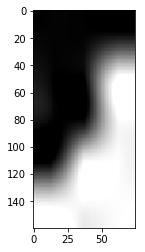

In [24]:
from PIL import Image

def cam_from_path(model_gap, img_path, img_height, img_width, weights, is_shown=False):
    img = image.load_img(img_path, target_size=(image_height, image_width, 3))
    img_arr = image.img_to_array(img)
    img_arr = np.expand_dims(img_arr, axis=0)
    #print(img_arr.shape)
    feature_map = model_gap.predict(img_arr)
    #print(feature_map.shape)
    array_feature_map = np.zeros(dtype=np.float32, shape=feature_map.shape[1:3])
    for i in range(0, feature_map.shape[3]):
        array_feature_map += weights[i] * feature_map[0, :, :, i]   
    array_feature_map -= np.average(array_feature_map)
    img_feature_map = Image.fromarray(array_feature_map.astype('uint8'))
    img_feature_map = img_feature_map.resize((image_width, image_height), Image.ANTIALIAS)
    if is_shown:
        plt.imshow(img_feature_map)
    return array_feature_map, np.asarray(img_feature_map)

def cam_from_array(model_gap, img_arr, img_height, img_width, weights, is_shown=False):
    img_arr = np.expand_dims(img_arr, axis=0)
    #print(img_arr.shape)
    feature_map = model_gap.predict(img_arr)
    #print(feature_map.shape)
    array_feature_map = np.zeros(dtype=np.float32, shape=feature_map.shape[1:3])
    for i in range(0, feature_map.shape[3]):
        array_feature_map += weights[i] * feature_map[0, :, :, i]   
    array_feature_map -= np.average(array_feature_map)
    img_feature_map = Image.fromarray(array_feature_map.astype('uint8'))
    img_feature_map = img_feature_map.resize((image_width, image_height), Image.ANTIALIAS)
    if is_shown:
        plt.imshow(img_feature_map)
    return array_feature_map, np.asarray(img_feature_map)
    
img_path = '/home/anhaoran/data/pedestrian_attributes_PETA/PETA/MIT/archive/00044_male_fore.jpg'
cam_from_path(model_gap, img_path, image_height, image_width, weights[:, 3], True)

# All Samples 

In [19]:
import pandas as pd
from progressbar import *

progress = ProgressBar()

filename = r"../results/PETA.csv"
data = np.array(pd.read_csv(filename))[:, 1:]
length = len(data)
data_x = np.zeros((length, image_height, image_width, 3))
data_y = np.zeros((length, class_num))
for i in progress(range(length)):
    #img = image.load_img(path + m)
    img = image.load_img(data[i, 0], target_size=(image_height, image_width, 3))
    data_x[i] = image.img_to_array(img)
    data_y[i] = np.array(data[i, 1:1+61], dtype="float32")
print("The shape of the X is: ", data_x.shape)
print("The shape of the y is: ", data_y.shape)
predictions_prob = model.predict(data_x)
print(predictions_prob.shape)

100% |########################################################################|


The shape of the X is:  (19000, 160, 75, 3)
The shape of the y is:  (19000, 61)
(19000, 61)


## 5*3

In [ ]:
import tqdm

## 5*3 for all dataset weighted by prediction prob
data_cam = np.zeros((class_num, 5, 3))
data_cam_train = np.zeros((class_num, 5, 3))
for i in tqdm.tqdm(range(length)):
    for attribute in range(data_y.shape[1]):
        if i==11400: data_cam_train[attribute] = data_cam[attribute]
        data_cam[attribute] += predictions_prob[i][attribute] * cam_from_array(model_gap, data_x[i], image_height, image_width, weights[:, attribute])[0]
np.save("../results/orig_feature_maps_dataset_weighted_by_predprob.npy", data_cam)
np.save("../results/orig_feature_maps_trainset_weighted_by_predprob.npy", data_cam_train)

 17%|█▋        | 3228/19000 [2:00:56<9:50:57,  2.25s/it] 

In [ ]:
## 5*3 for all dataset weighted by label
data_cam = np.zeros((class_num, 5, 3))
data_cam_train = np.zeros((class_num, 5, 3))
for i in tqdm.tqdm(range(length)):
    for attribute in range(data_y.shape[1]):
        if i==11400: data_cam_train[attribute] = data_cam[attribute]
        data_cam[attribute] += data_y[i][attribute] * cam_from_array(model_gap, data_x[i], image_height, image_width, weights[:, attribute])[0]
np.save("../results/orig_feature_maps_dataset_weighted_by_label.npy", data_cam)
np.save("../results/orig_feature_maps_trainset_weighted_by_label.npy", data_cam_train)

## 160*75

In [ ]:
## 160*75 for all dataset weighted by prediction prob
data_cam = np.zeros((class_num, 160, 75))
data_cam_train = np.zeros((class_num, 160, 75))
for i in tqdm.tqdm(range(length)):
    for attribute in range(data_y.shape[1]):
        if i == 11400: data_cam_train[attribute] = data_cam[attribute]
        data_cam[attribute] += predictions_prob[i][attribute] * cam_from_array(model_gap, data_x[i], image_height, image_width, weights[:, attribute])[1]
np.save("../results/resize_feature_maps_dataset_weighted_by_predprob.npy", data_cam)
np.save("../results/resize_feature_maps_trainset_weighted_by_predprob.npy", data_cam_train)

In [ ]:
## 160*75 for all dataset weighted by label
data_cam = np.zeros((class_num, 160, 75))
data_cam_train = np.zeros((class_num, 160, 75))
for i in tqdm.tqdm(range(length)):
    for attribute in range(data_y.shape[1]):
        if i == 11400: data_cam_train[attribute] = data_cam[attribute]
        data_cam[attribute] += data_y[i][attribute] * cam_from_array(model_gap, data_x[i], image_height, image_width, weights[:, attribute])[1]
np.save("../results/resize_feature_maps_dataset_weighted_by_label.npy", data_cam)
np.save("../results/resize_feature_maps_trainset_weighted_by_label.npy", data_cam_train)

# Cluster

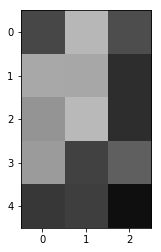

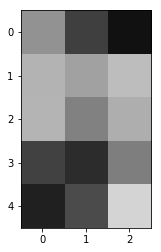

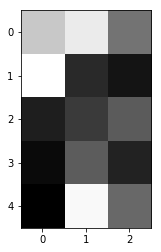

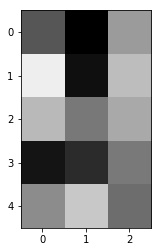

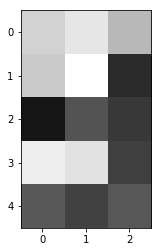

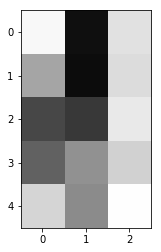

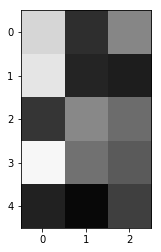

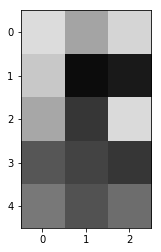

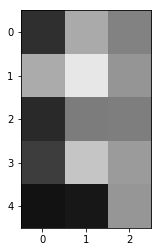

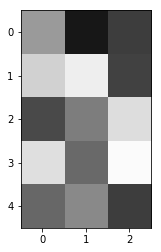

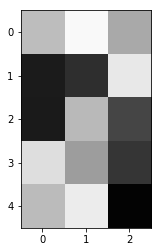

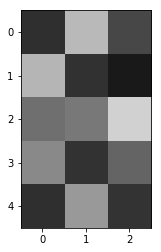

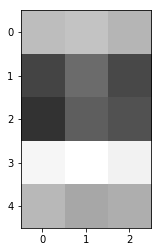

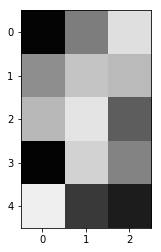

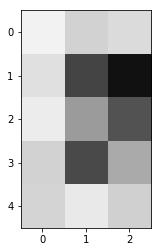

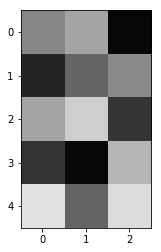

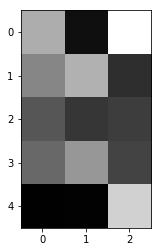

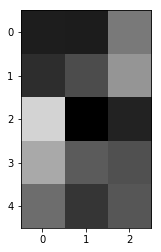

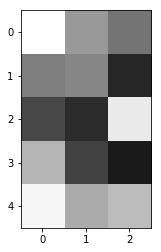

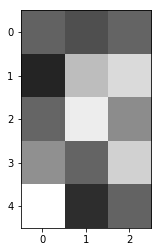

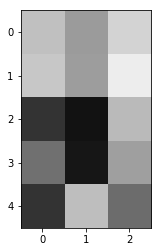

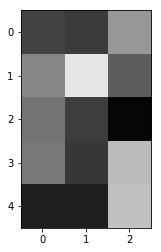

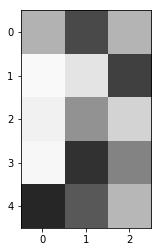

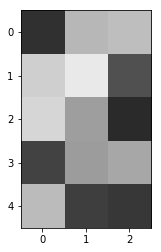

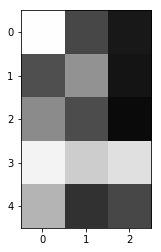

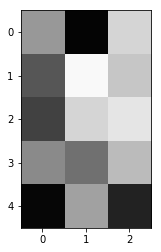

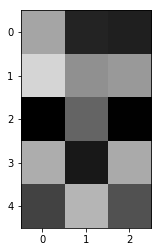

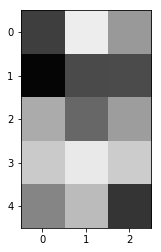

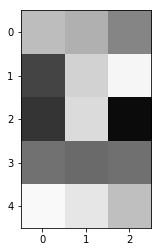

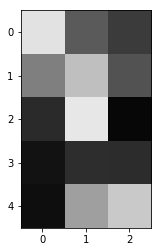

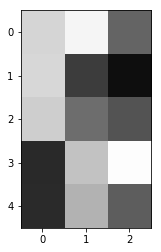

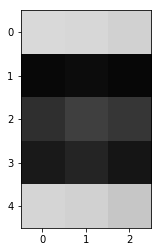

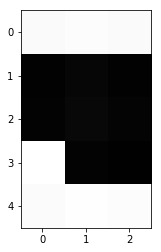

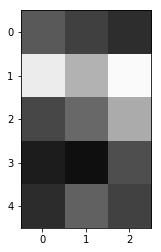

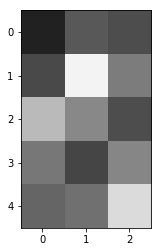

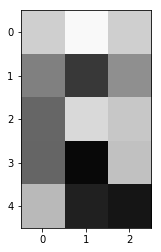

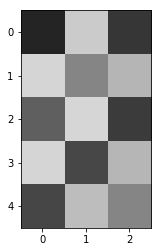

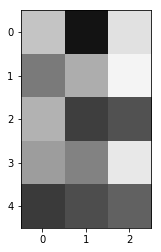

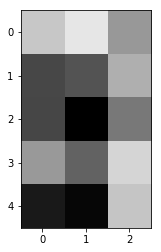

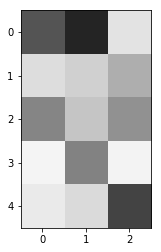

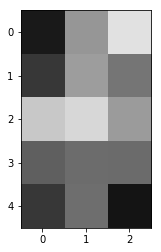

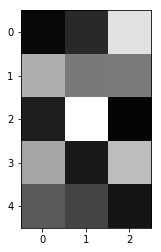

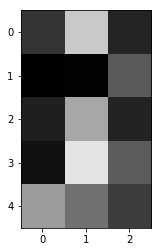

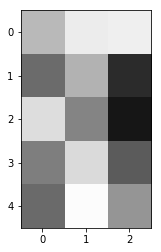

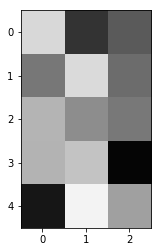

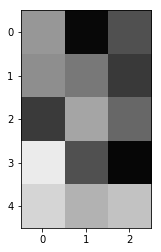

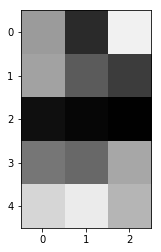

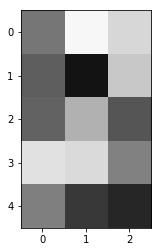

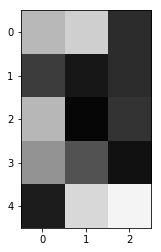

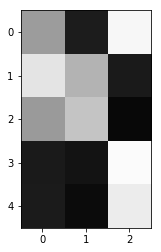

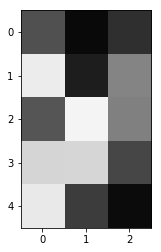

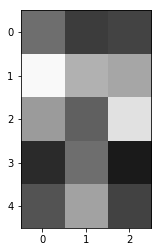

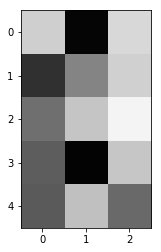

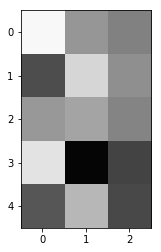

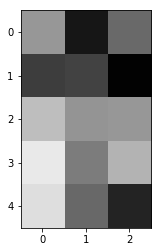

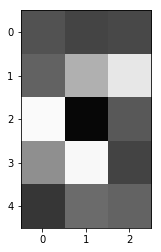

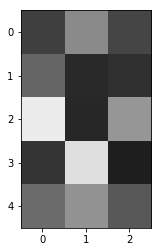

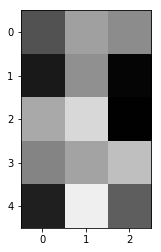

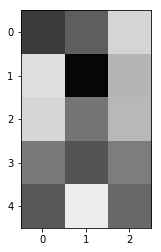

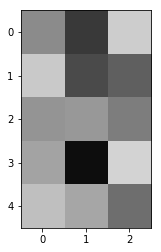

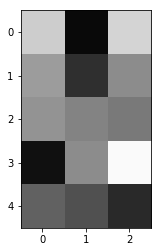

(61, 15)


In [124]:
#acc_features = np.load("../results/orig_feature_maps_dataset_weighted_by_label.npy")
#acc_features = np.load("../results/orig_feature_maps_dataset_weighted_by_predprob.npy")
#acc_features = np.load("../results/orig_feature_maps_trainset_weighted_by_label.npy")
acc_features = np.load("../results/orig_feature_maps_trainset_weighted_by_predprob.npy")
#acc_features = np.load("../results/resize_feature_maps_dataset_weighted_by_label.npy")
#acc_features = np.load("../results/resize_feature_maps_dataset_weighted_by_predprob.npy")
#acc_features = np.load("../results/resize_feature_maps_trainset_weighted_by_label.npy")
#acc_features = np.load("../results/resize_feature_maps_trainset_weighted_by_predprob.npy")
img_arr = acc_features - np.average(acc_features)
for img in img_arr:
    img = Image.fromarray(img.astype('uint8'))
    plt.imshow(img)
    plt.show()
acc_features = acc_features.reshape((61, -1))
print(acc_features.shape)

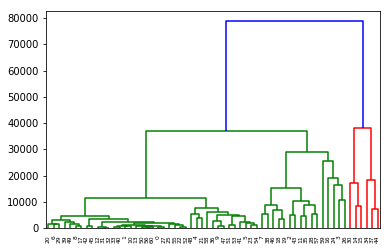

Original cluster by hierarchy clustering:
 [ 6  4 16 19  9 12  1 14  1 10  4 17  3  7 20 20 19  1 15 15  1  9  8 12
 19  8 19  6 18  1 20  3  3  4 21 17 10 21 14  1  4 12  2 16 21  2 15 10
  9  1  5 11  8 11 12  8  5 18 13 19  5]


In [125]:
import scipy
import scipy.cluster.hierarchy as sch
from scipy.cluster.vq import vq,kmeans,whiten
import matplotlib.pyplot as plt

#1. 层次聚类
#生成点与点之间的距离矩阵,这里用的欧氏距离:
disMat = sch.distance.pdist(acc_features,'euclidean') 
#进行层次聚类:
Z=sch.linkage(disMat,method='average') 
#将层级聚类结果以树状图表示出来并保存为plot_dendrogram.pn
P=sch.dendrogram(Z)
plt.show()
#根据linkage matrix Z得到聚类结果:
cluster= sch.fcluster(Z, t=1, criterion='inconsistent') 

print("Original cluster by hierarchy clustering:\n",cluster)

In [126]:
#使用kmeans函数进行聚类,输入第一维为数据,第二维为聚类个数k.
#有些时候我们可能不知道最终究竟聚成多少类,一个办法是用层次聚类的结果进行初始化.当然也可以直接输入某个数值. 
#k-means最后输出的结果其实是两维的,第一维是聚类中心,第二维是损失distortion,我们在这里只取第一维,所以最后有个[0]
cluster_number = 3#np.max(cluster)
centroid=kmeans(acc_features, cluster_number)[0]#max(cluster)

#使用vq函数根据聚类中心对所有数据进行分类,vq的输出也是两维的,[0]表示的是所有数据的label
label=vq(acc_features, centroid)[0] 

print("Final clustering by k-means:\n",label)

Final clustering by k-means:
 [0 0 1 1 0 0 0 1 0 0 0 1 0 0 2 2 2 0 1 1 0 0 0 0 1 0 1 0 1 0 2 0 0 0 2 1 0
 2 1 0 0 0 0 1 2 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0]


In [127]:
levels = []
indexs = []
for i in range(cluster_number):
    levels.append(list())
    indexs.append(list())
for i in range(61):
    levels[label[i]].append(attributes_list[i])
    indexs[label[i]].append(i)
for level in levels:
    print(level)
print(indexs)

['upperBodyLogo', 'lowerBodyThinStripes', 'accessoryHeadphone', 'carryingBabyBuggy', 'carryingBackpack', 'footwearBoots', 'carryingOther', 'carryingShoppingTro', 'carryingFolder', 'accessoryHairBand', 'lowerBodyJeans', 'hairLong', 'lowerBodyLongSkirt', 'upperBodyLongSleeve', 'carryingLuggageCase', 'accessoryMuffler', 'carryingNothing', 'carryingPlasticBags', 'footwearShoes', 'hairShort', 'lowerBodyShorts', 'footwearSneakers', 'carryingSuitcase', 'lowerBodySuits', 'accessorySunglasses', 'upperBodySweater', 'upperBodyOther', 'personalLess15', 'personalLess30', 'personalLess45', 'personalLess60', 'personalLarger60', 'lowerBodyCapri', 'lowerBodyCasual', 'upperBodyCasual', 'personalFemale', 'lowerBodyFormal', 'lowerBodyPlaid', 'upperBodyPlaid']
['upperBodyThinStripes', 'upperBodyThickStripes', 'hairBald', 'carryingUmbrella', 'accessoryKerchief', 'footwearLeatherShoes', 'carryingMessengerBag', 'accessoryNothing', 'upperBodyNoSleeve', 'lowerBodyShortSkirt', 'upperBodySuit', 'lowerBodyTrousers